In [1]:
!pip install datasets transformers evaluate imbalanced-learn umap-learn wandb GPUtil seaborn pandas numpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 KB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 43.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 KB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 KB 1.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 37.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 KB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━

In [2]:
import gc
import torch
gc.collect()
torch.cuda.empty_cache()

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
import pandas as pd

# Pubhealth Dataset

PUBHEALTH is a comprehensive dataset for explainable automated fact-checking of public health claims. Each instance in the PUBHEALTH dataset has an associated veracity label (true, false, unproven, mixture). Furthermore each instance in the dataset has an explanation text field. The explanation is a justification for which the claim has been assigned a particular veracity label.

Dataset link: https://huggingface.co/datasets/health_fact

In [5]:
from datasets import load_dataset

health_fact = load_dataset('health_fact')

Generating train split:   0%|          | 0/9832 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1235 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1225 [00:00<?, ? examples/s]

Dataset health_fact downloaded and prepared to /root/.cache/huggingface/datasets/health_fact/default/1.1.0/99503637e4255bd805f84d57031c18fe4dd88298f00299d56c94fc59ed68ec19. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

Not mentioned in the dataset card on Hugging Face, is that as well as the four veracity labels, there is an additional "invalid" label which is represented with a -1.  

These need to be removed from the train, validation and test sets to avoid problems later, such as errors when training ML models.

In [6]:
# Filter out instances with a -1 label
health_fact['train'] = health_fact['train'].filter(lambda x: x['label'] != -1)
health_fact['validation'] = health_fact['validation'].filter(lambda x: x['label'] != -1)
health_fact['test'] = health_fact['test'].filter(lambda x: x['label'] != -1)

Filter:   0%|          | 0/9832 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1225 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1235 [00:00<?, ? examples/s]

Let's have a quick look at the sort of data we have in the dataset by converting to a Pandas format, adding in a column for the label names

In [7]:
health_fact.set_format(type="pandas")
df = health_fact["train"][:]

def label_int2str(row):
    if row == -1:
        return 'invalid'
    return health_fact["train"].features["label"].int2str(row)

df["label_name"] = df["label"].apply(label_int2str)

df.head()

,claim_id,claim,date_published,explanation,fact_checkers,main_text,sources,label,subjects,label_name
0,15661,"""The money the Clinton Foundation took from fr...","April 26, 2015","""Gingrich said the Clinton Foundation """"took m...",Katie Sanders,"""Hillary Clinton is in the political crosshair...",https://www.wsj.com/articles/clinton-foundatio...,0,"Foreign Policy, PunditFact, Newt Gingrich,",false
1,9893,Annual Mammograms May Have More False-Positives,"October 18, 2011",This article reports on the results of a study...,,While the financial costs of screening mammogr...,,1,"Screening,WebMD,women's health",mixture
2,11358,SBRT Offers Prostate Cancer Patients High Canc...,"September 28, 2016",This news release describes five-year outcomes...,"Mary Chris Jaklevic,Steven J. Atlas, MD, MPH,K...",The news release quotes lead researcher Robert...,https://www.healthnewsreview.org/wp-content/up...,1,"Association/Society news release,Cancer",mixture
3,10166,"Study: Vaccine for Breast, Ovarian Cancer Has ...","November 8, 2011","While the story does many things well, the ove...",,"The story does discuss costs, but the framing ...",http://clinicaltrials.gov/ct2/results?term=can...,2,"Cancer,WebMD,women's health",true
4,11276,Some appendicitis cases may not require ’emerg...,"September 20, 2010",We really don’t understand why only a handful ...,,"""Although the story didn’t cite the cost of ap...",,2,,true


## Frequency of the Different Classes

Having added the label names, we can now easily see the relative frequency of the different classes

Text(0.5, 1.0, 'Frequency of Classes')

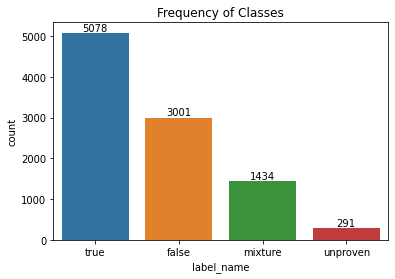

In [8]:
ax = sns.countplot(x='label_name', data=df, order = df['label_name'].value_counts().index)
ax.bar_label(ax.containers[0])
plt.title("Frequency of Classes")

## Number of Words in Different Text Fields

The dataset includes text fields that outline the "claim", the "explanation" and a "full text".  In the graphs below we can see the distributions of word counts for the different labels

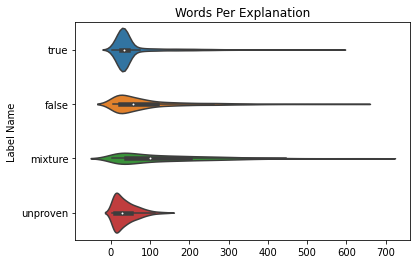

In [9]:
def words_per_plot(column_name ='explanation'):
    name = column_name.title()
    title = f'Words Per {name}'.replace('_', ' ')
    df[title] = df[column_name].str.split().apply(len)
    sns.violinplot(x=df[title], y=df['label_name'], data=df, order = df['label_name'].value_counts().index)
    plt.title(title)
    plt.xlabel("")
    plt.ylabel("Label Name")

words_per_plot()

Here we can see variation in the distributions of number of words per explanation.  It doesn't seem like the differences are so extensive as to make word count a great feature as the means of each distribution are within the body of the violin in each case.  Interestingly they all have long tails, with the exception of the "unproven" category

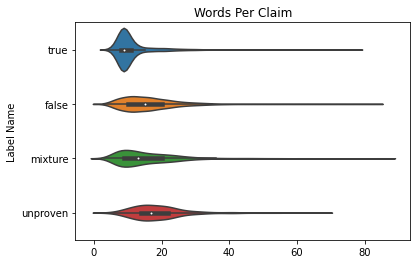

In [10]:
words_per_plot('claim')

Here we can see variation in the distributions of number of words per per claim.  Understandably the claims are generally much shorter than the explanations, and "true" claims do tend to be a little shorter than the other.

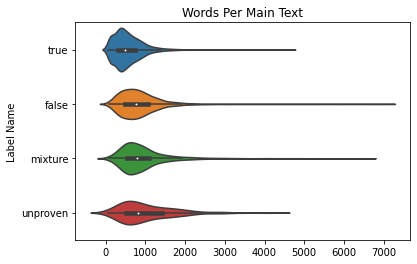

In [11]:
words_per_plot('main_text')

Finally we can see the numbers of words in the main text.  These are significantly longer than the other text fields.  

## Distribution of Dates

We can create a similar distribution of the dates when claims were published.  Several of the classes have multi model distributions but there is heavy overlap between the distributions

Text(0, 0.5, 'Year')

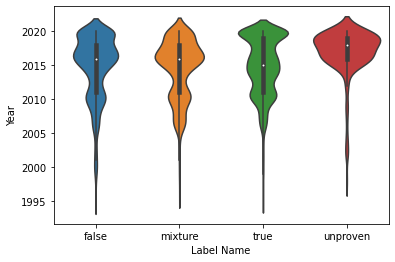

In [12]:
df_copy = df.copy()
df_copy.loc[:,'date'] = pd.to_datetime(df['date_published'], format='%B %d, %Y', errors='coerce')

df_copy = df_copy.copy()
df_copy.loc[:,'year'] = df_copy['date'].dt.year

sns.violinplot(x=df_copy['label_name'], y='year', data=df_copy)
plt.xlabel("Label Name")
plt.ylabel("Year")

## Distribution of Fact Checkers, Subjects and Sources 

Below we look at heatmaps at the most frequent sources, fact checkers and subjects for each of the different classes

In [13]:
import re
# Define a function to split a list of names on comma, "and", or ampersand
def split_names(names):
    # Split on comma or " and " or " & "
    pattern = r',|\s+(and|And)\s+|\s+&(\s+amp;)?\s+'
    split_names = re.split(pattern, names)
    # Clean up the resulting names
    cleaned_names = [name.strip() for name in split_names if name]
    return cleaned_names

<Axes: xlabel='label_name', ylabel='f{column_name}_clean'>

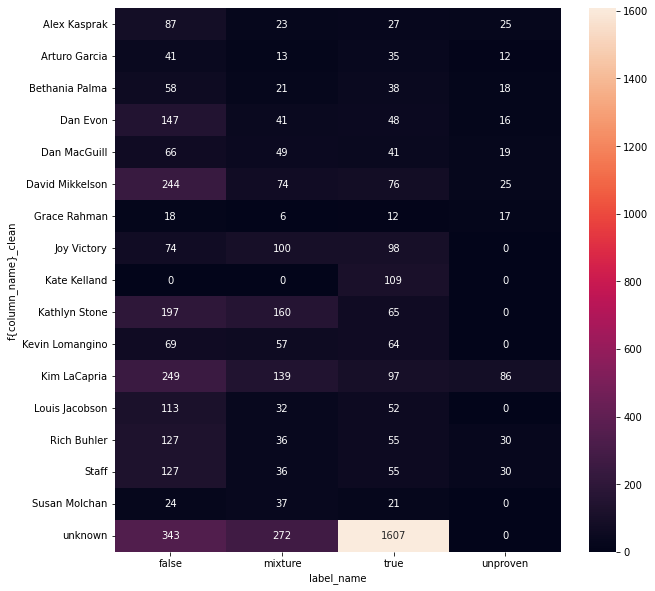

In [14]:
def create_pivot_for_heatmap(column_name = 'fact_checkers'):
    new_column_name = 'f{column_name}_clean'
    df[new_column_name] = df[column_name].apply(split_names).apply(lambda list: [*map(lambda name: name.strip() if name.strip() != '' else 'unknown', list)])
    exploded_df = df.explode(new_column_name)

    # Drop rows with missing fact checker values
    exploded_df = exploded_df.dropna(subset=[new_column_name])
    # Remove qualifications like 'MD', 'MPH', 'PhD', 'MA', 'MS', 'MPA', 'DrPH', 'FACS', 'MHS', 'MBBS', 'FAAFP', 'MSJ'
    exploded_df = exploded_df[exploded_df[new_column_name].str.len() > 4] 

    # Group the data by label_name and fact_checkers and count the number of rows in each group
    df_count = exploded_df.groupby(['label_name', new_column_name]).size().reset_index(name='frequency')
    df_count['frequency'] = df_count['frequency'].astype(int)
    df_count['frequency'] = pd.to_numeric(df_count['frequency'], errors='coerce')

    df_pivot = df_count.pivot(index=new_column_name, columns='label_name', values='frequency')
    df_pivot = df_pivot.fillna(0)

    # # Get the top 10 fact checkers for each label_name
    top_fact_checkers = []
    for label_name in df_pivot.columns:
        array = list(df_pivot[label_name].nlargest(10).index)
        for element in array:
            top_fact_checkers.append(element)

    df_filtered = df_count[df_count[new_column_name].isin(top_fact_checkers)]
    df_filtered

    df_pivot = df_filtered.pivot(index=new_column_name, columns='label_name', values='frequency')
    return df_pivot.fillna(0)

df_pivot = create_pivot_for_heatmap()
fig, ax = plt.subplots(figsize=(10, 10))

# # Create a heatmap of the frequency with which each fact checker has been involved in each type of claim
sns.heatmap(data=df_pivot, annot=True, fmt='g')


<Axes: xlabel='label_name', ylabel='f{column_name}_clean'>

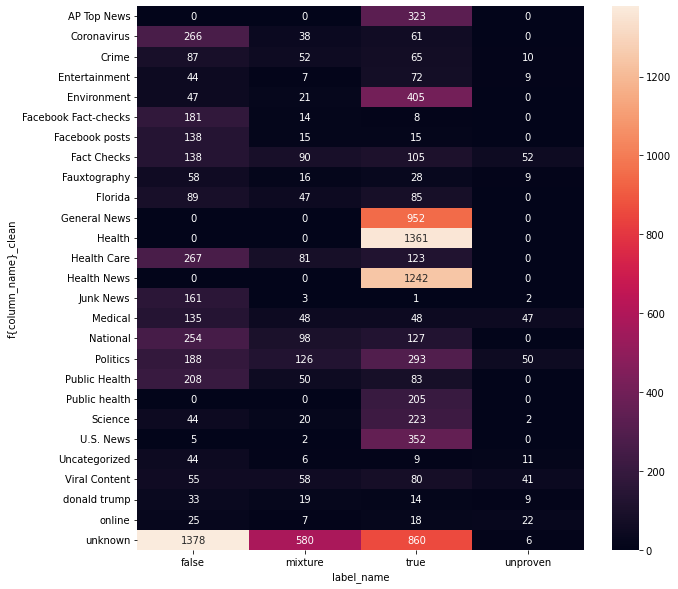

In [15]:
df_pivot = create_pivot_for_heatmap('subjects')
fig, ax = plt.subplots(figsize=(10, 10))

# # Create a heatmap of the frequency with which each subject has been involved in each type of claim
sns.heatmap(data=df_pivot, annot=True, fmt='g')


<Axes: xlabel='label_name', ylabel='f{column_name}_clean'>

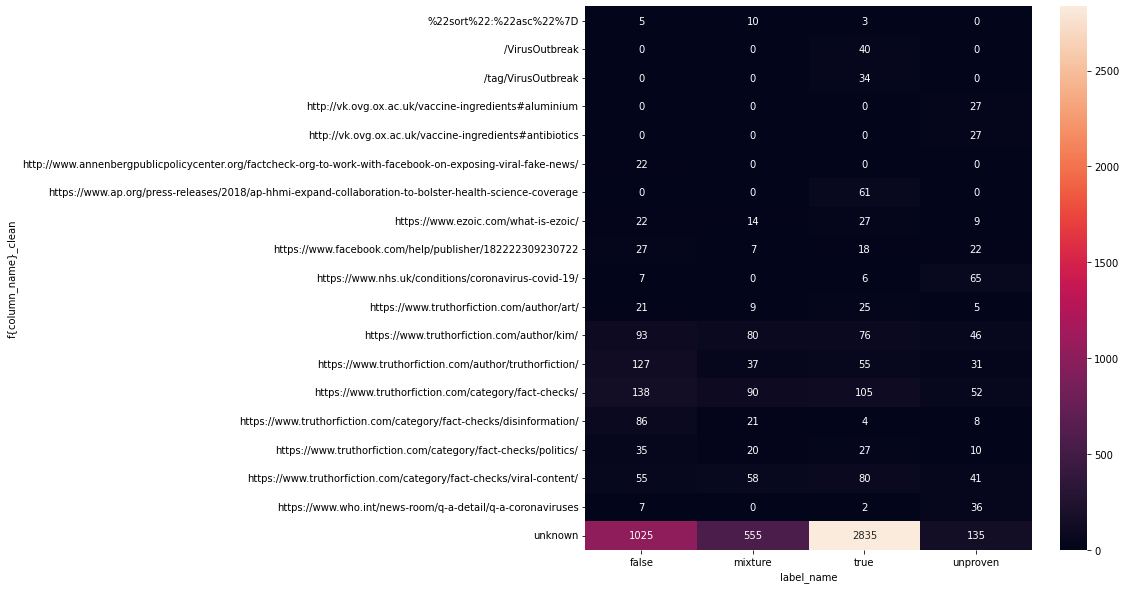

In [16]:
df_pivot = create_pivot_for_heatmap('sources')
fig, ax = plt.subplots(figsize=(10, 10))

# # Create a heatmap of the frequency with which each source has been involved in each type of claim
sns.heatmap(data=df_pivot, annot=True, fmt='g')

We can see some patterns here in that claims where the fact checkers were "unknown" tended to be "true", and certain fact checkers were more involved in claims of one kind than another.  In addition certain subjects are much more likely to be "true", e.g. health care, while "unknown" sources seems to be an indicator of "true" stories.  These aspects likely reflect the trends within the different datasets being gathered into this dataset, but it's interesting to consider whether we could use these distribtions to predict the veracity of the claim to some degree of accuracy.

## Conclusion

We can see that the classes in the dataset are somewhat imbalanced. The words per explanation are an appropriate amount for the 512 limit on most transformers.  Also note that superficial features in the dataset do not obviously distinguish the veracity classes.  The one exception is that the subject of the claim was quite skewed in some cases.  For example all the claims in the "Health" and "General news" subjects are "true", while the majority of the claims in the "Coronavirus" are false.